In [1]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('../library/')
from models import *
from Epi_models import*
from functions import *
import networkx as nx
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.lines import Line2D
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
Text_files_path = '../Text_files/Testing_Networks/'

%autosave 60

Autosaving every 60 seconds


# Stochastic simulations on Networks

In [4]:
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.watts_strogatz_graph(N, 4, 1)

## Network and degree distribution (uncomment to update $k$ and $p_k$)

#----Load data network of contacts----
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
nodeDegrees = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/network_degree_distrib_N%d.txt'%(N), dtype=np.int32)
meanDegree = np.mean(nodeDegrees)
meanDegree2 = np.mean(nodeDegrees**2)
degree_distrib = np.histogram(nodeDegrees, bins=np.arange(1, np.max(nodeDegrees)+1), density = False)
k = degree_distrib[1][:-1]
p_k = degree_distrib[0]/len(nodeDegrees)

outfile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','wb')
pickle.dump(k, outfile_k)
outfile_k.close()
outfile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','wb')
pickle.dump(p_k, outfile_p_k)
outfile_p_k.close()
print(meanDegree, meanDegree2, np.max(nodeDegrees))

In [5]:
infile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','rb')
k = pickle.load(infile_k)
infile_k.close()
infile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','rb')
p_k = pickle.load(infile_p_k)
infile_p_k.close()

meanDegree = np.sum(k*p_k)
meanDegree2 = np.sum(k**2*p_k)
print(meanDegree)
print(np.max(k))

3.9960271618768215
265


## Single Trajectory

12.002999750075354 11.999999999999998


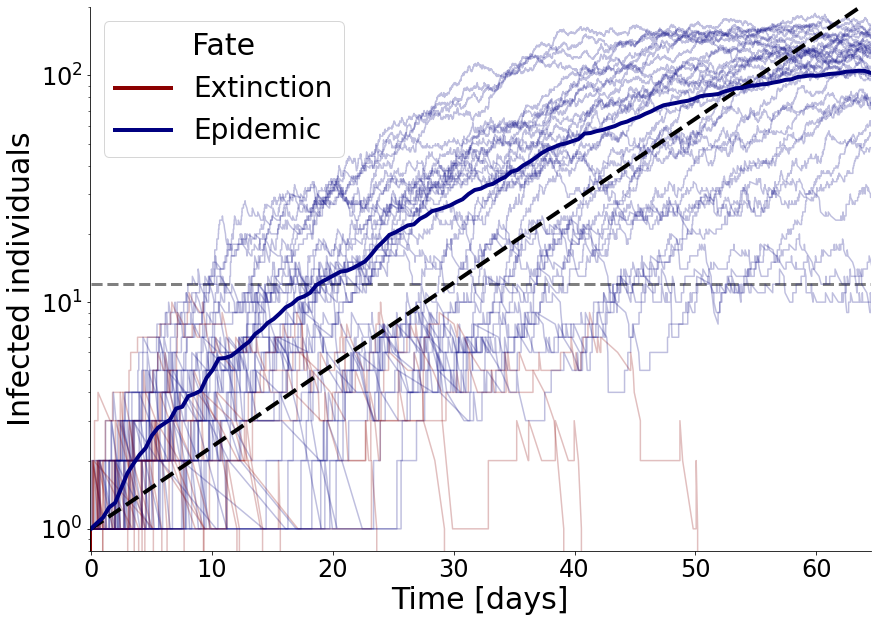

In [6]:
intervals = 100
p=1.0
gamma = 1/6
sigma = 1000
R0 = 1.5 #use 1.5 and 4.0
beta = R0*gamma
T_total = 65 #use 65 and 12
intervals = T_total*2
repetitions = 100
lambda1 = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta)
est = 1/(lambda1)
print(est, 1/(beta-gamma))
colors_status = ['darkred', 'navy']

fig, ax = plt.subplots(figsize=(14,10))

### run function 
G = nx.barabasi_albert_graph(N, 50)
E_avg = np.zeros(shape=(2, intervals))
I_avg = np.zeros(shape=(2, intervals))
n_epi = 0

T_avg = np.linspace(0, T_total, intervals)
for i in np.arange(repetitions):
    t, E_t, I_t, status = run_network_trajectory(N, G, beta, sigma, gamma, T_total, p, initE = 0, initI = 1, folder = Text_files_path +'Stochastic/Networks/'+graphs_names[0], save = False)
    E_avg_temp, I_avg_temp = regularize_time_series(T_total = T_total, intervals = intervals, t = t, E_t = E_t, I_t = I_t)
    E_avg[status, :] += E_avg_temp
    I_avg[status, :] += I_avg_temp
    n_epi += status
    ax.plot(t, I_t, color = colors_status[status], alpha = .25)
    
lambda1, lambda2, time, E_solution, I_solution, sol_total_approx, I_max_2 = run_deterministic(N, beta, sigma, gamma, p, T_total, folder = Text_files_path +'Deterministic/Single_trajectory')
ax.plot(time, I_solution, color = 'black', ls = '--', lw = 4)
ax.plot(T_avg, I_avg[0,:]/(repetitions-n_epi), color = colors_status[0], label = 'Extinction', lw = 4)
ax.plot(T_avg, I_avg[1,:]/n_epi, color = colors_status[1], label = 'Epidemic', lw = 4)
#ax.plot(T_avg, (I_avg[0,:]+I_avg[1,:])/(repetitions), color = 'silver', lw = 3)
ax.hlines(est, 0, T_total, color = 'grey', lw = 3, linestyle = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom = .8, top = 2e2)
ax.set_xlim(-0.1, T_total-0.5)
my_plot_layout(ax = ax, yscale = 'log', xlabel = 'Time [days]', ylabel = 'Infected individuals', x_fontsize = 30, y_fontsize = 30)
ax.legend(fontsize = 28, loc = 2, title = 'Fate', title_fontsize = 30)

fig.savefig('../figures/Stochastic/Networks/'+graphs_names[0]+'/Trajectories/pdfs/figure_trajectories_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma, sigma, N, p)+'.pdf')


## Ensemble

In [26]:
sample_sizes = [150, 250, 400]
colors = ['b', 'g', 'r']
colors2 = ['purple', 'violet', 'brown']
N = 2000
print('N:', N)
gamma = 1/6
print('Gamma:', gamma)
sigma = 1/4
print('Sigma:', sigma)
graphs = [G1]
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
sampling_protocol = np.array(['uniform', 'aposteriori'])
folders  = np.array(['../figures/Control/Stochastic/Ensemble/Networks/', '../../Figures/Stochastic/Networks/'])

#ps = np.array([0.0])
ps = np.array([0.0, 1.0])
print('ps:',ps)
#n_sims = np.array([100, 100, 100, 100, 100])
n_sims = np.array([1000, 100000, 100000, 100000, 100000])
print('n_sim:',n_sims)

#R0s = np.array([1.2, 2.0, 3.0, 4.5])
#R0s2 = np.array([0.8, 1.2, 2.0, 3.0, 4.5]) # with network p=0
R0s = np.array([6.0])
R0s2 = np.array([6.0])

Betas = np.array([R0s2*gamma,R0s*gamma])
print('Betas:', Betas)

R0_Ns = (R0s2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0s2))
R0_Es = np.sqrt(1-4*((sigma*gamma-sigma*Betas[0])/(sigma + gamma)**2))
R0_ENs = (R0_Es*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0_Es))

print('R0s:', R0s2)
print('R0_Es:',R0_Es)
print('R0_Ns:',R0_Ns)
print('R0_ENs:',R0_ENs)

lambdas = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*Betas[1]) #exponential growth rates

ests = (1/(lambdas)).astype(int)
if(sigma==1/4):
    est_Ns = (1/((R0_ENs-1)*gamma)).astype(int)
if(sigma==1000):
    est_Ns = (1/((R0_Ns-1)*gamma)).astype(int)

Ts_Total = np.array([4*ests,4*ests]) #for R0 = [1.2, 1.5, 3.0, 4.5] use [160, 35, 20] and half of it if when sigma=1000
print('Times:',Ts_Total)
slopes = np.array([1, 1, 1, 1, 1, 1])
print('slopes:',slopes)

aposteriori = False
print('Aposteriori:',aposteriori)


N: 2000
Gamma: 0.16666666666666666
Sigma: 0.25
ps: [0. 1.]
n_sim: [  1000 100000 100000 100000 100000]
Betas: [[1.]
 [1.]]
R0s: [6.]
R0_Es: [2.40831892]
R0_Ns: [6.49437906]
R0_ENs: [4.06867514]
Times: [[12]
 [12]]
slopes: [1 1 1 1 1 1]
Aposteriori: False


In [27]:
%%time
##Run over values of p
for p, Ts_total, betas in zip (ps, Ts_Total, Betas):
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta, T_total, slope, n_sim in zip (betas, Ts_total, slopes, n_sims):
            print('T:', T_total )
            print('p:',p)
            print('R0:', beta/gamma)
            if(aposteriori):
                print('slope:',slope)
            print('Succ nodes:')
            ### Generate new graph
            G = nx.barabasi_albert_graph(N, 2)
            ### run function 
            %time run_network_ensemble(N=N, G=G, G_name=G_name, beta=beta, sigma=sigma, gamma=gamma, T_total=T_total, intervals=T_total+1, n_ensemble=n_sim, p = p, initE=0, initI=1, folder = Text_files_path +  'Stochastic/Networks/'+G_name+'/k_normalization', stochastic = True, sampling = False, sample_sizes = sample_sizes, aposteriori=aposteriori, slope = slope)
            print('\n')
            

T: 12
p: 0.0
R0: 6.0
Succ nodes:
393
CPU times: user 52.6 s, sys: 2.42 s, total: 55 s
Wall time: 55.2 s


T: 12
p: 1.0
R0: 6.0
Succ nodes:
760
CPU times: user 1min 37s, sys: 2.67 s, total: 1min 40s
Wall time: 1min 40s


CPU times: user 2min 30s, sys: 5.09 s, total: 2min 35s
Wall time: 2min 35s


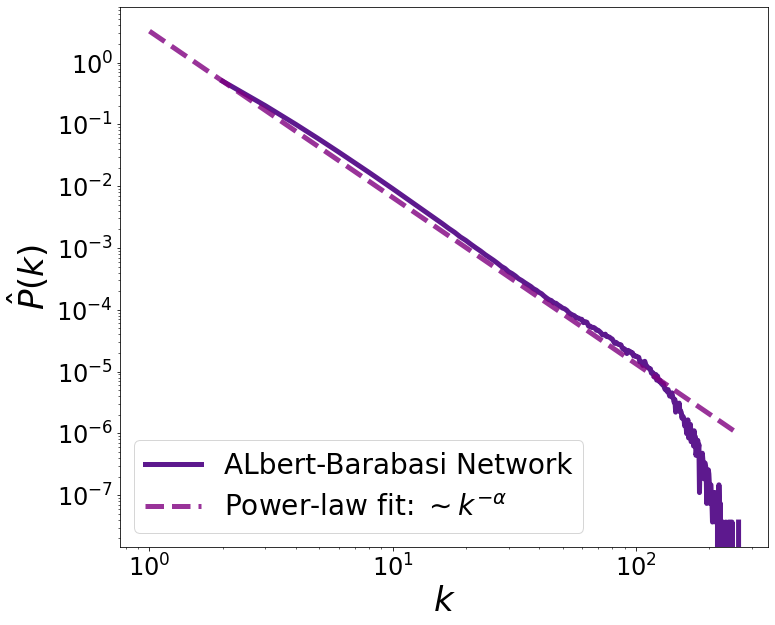

In [7]:
fig, ax = plt.subplots(figsize=(12,10), gridspec_kw={'bottom': 0.13,'left':.15})
ax.plot(k[1:], p_k[1:], marker = '', ms = '13', ls = '-', color = 'indigo', lw = 5, alpha = .9, label = 'ALbert-Barabasi Network')
popt, potv = curve_fit(my_linear_function, np.log(k[1:-150][p_k[1:-150]!=0]), np.log(p_k[1:-150][p_k[1:-150]!=0]))
ax.plot(k[:], (k[:].astype(float)**(popt[1]))*((p_k[1:][0])/(k[1:].astype(float)**(popt[1]))[0]), marker = '', ms = '12', ls = '--', color = 'purple', lw = 5, alpha = .8, label = r'Power-law fit: $\sim k^{-\alpha}$')
my_plot_layout(ax = ax, yscale = 'log', xscale = 'log', xlabel= r'$k$', ylabel= r'$\hat{P}(k)$', x_fontsize = 34, y_fontsize = 34)
ax.legend(fontsize = 28, loc = 3)
fig.savefig('../figures/Stochastic/Networks/barabasi-albert/pdfs/Degree_distribution.pdf')
fig.savefig('../figures/Stochastic/Networks/barabasi-albert/Degree_distribution.png')
